# Quantitative Stock Selection

In [17]:
import yfinance as yf 

import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import math
from time import sleep
import quandl
import seaborn as sns
import sys
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

## Functions

In [18]:
# FUNCTIONS FOR VIEWING SINGLE COMPANY RANKINGS 

def company(company):
    for i in data['Company']:
        if company in i or company in i.lower():
            return data.loc[data['Company'] == i]
    print('No company found')
    
def Company(company):
    for i in data['Company']:
        if company in i or company in i.lower():
            stock = data.loc[data['Company'] == i]
            stock = stock[compact]
            return stock
    print('No company found')

In [19]:
def mod_Z_score(data):
    mean = np.mean(data.iloc[:-1])
    deviation_from_med = np.array(data.iloc[:-1]) - mean
    MAD = np.mean(np.abs(deviation_from_med))
    mod_Z = (data[-1:] - mean)/(MAD * 1.4826)
    return mod_Z

## Data Import and Wrangling

In [20]:
# IMPORT LATEST DATA 

data_tmp = pd.read_excel("equity_data/Borsdata_2021-09-10.xlsx", sheet_name="Export")
data_tmp = data_tmp[1:]

data_tmp = data_tmp.rename({'Performance - Perform. 3m' : 'Return 3m','Performance - Perform. 6m' : 'Return 6m',
                            'Performance - Perform. 1y' : 'Return 1y',
                            'Div. Yield - Current': 'Yield', 
                            'Total Equity  - Millions':'Total Equity', 'FCF - Millions': 'FCF','ROE - Current':'ROE',
                            'Volatility - St.Dev. 100d':'Volatility','Market Cap - Current': 'Market Cap', 
                            'ROC - Current':'ROC', 'Tot. Assets - Millions':'Tot. Assets', 
                            'Gross profit - Millions':'Gross profit', 'Assets Turn - Current': 'Assets Turn',
                            'P/FCF - Current':'P/FCF', 'P/E - Current':'P/E', 'P/S - Current':'P/S',
                            'P/B - Current':'P/B','EV/EBIT - Current':'EV/EBIT',
                            'Info - Country' : 'Country','F-Score - Point':'F-Score',
                            'Info - List' : 'List', 'Info - Sector' : 'Sector', 'Info - Industry' : 'Industry',
                            'Info - Ticker' : 'Tick', 'Info - Yahoo':'Yahoo', 'Info - Last Report': 'Last Report',
                           'Volume - Average 50d Mill' : 'Volume'}, axis=1)

# FORMAT FOR VIEWING PLEASURE
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format

In [21]:
# MAKE NUMBERS FLOATS 

data_tmp['Market Cap'] = data_tmp['Market Cap'].replace(',', '') # remove , as 1000 separator

list = ['P/E', 'EV/EBIT', 'P/FCF', 'P/S', 'P/B', 'Assets Turn', 'Gross profit', 'Tot. Assets', 'ROC', 'Yield', 'Market Cap', 'Volatility',
        'F-Score', 'ROC', 'ROE', 'FCF', 'Total Equity', 
        'Return 3m', 'Return 6m', 'Return 1y']

for i in list: 
    data_tmp[i] = pd.to_numeric(data_tmp[i]) # make every number numeric


data_tmp['FCFROE'] = data_tmp['FCF']/data_tmp['Total Equity'] # calc FCFROE
data_tmp['GPA'] = data_tmp['Gross profit']/data_tmp['Tot. Assets'] 

In [22]:
### FILTER DATA FOR VOLUME, LIST AND MARKET CAP

data_tmp = data_tmp.loc[data_tmp['Market Cap'] > 500]
#data_tmp = data_tmp.loc[(data_tmp['List'] != 'First North') & (data_tmp['List'] != 'Spotlight') 
#                        & (data_tmp['List'] != 'NGM')]

data_tmp = data_tmp.loc[ (data_tmp['List'] != 'Spotlight') 
                        & (data_tmp['List'] != 'NGM')]

#Volume Filter
data_tmp = data_tmp.loc[data_tmp['Volume'] > 0.7]

# Set to dattime
data_tmp['Last Report'] = pd.to_datetime(data_tmp['Last Report'])

#set new index
data_tmp.index = range(len(data_tmp.index))

## Calculate Price Based Data from Yahoo Finance

In [41]:
## Get PEAD
data_tmp["EA ret"] = np.nan
data_tmp["EA ret std"] = np.nan
data_tmp['1 Year Volatility'] = np.nan
data_tmp['1 Year MAD'] = np.nan
data_tmp['Ret ID'] = np.nan
data_tmp['Beta'] = np.nan
index = yf.download('^OMXSPI',start='2020-01-01')
index = index['Close']

[*********************100%***********************]  1 of 1 completed


In [42]:
for i in range(len(data_tmp)):
    if data_tmp.iloc[i]['Yahoo'] != 'SDIP.ST':
        try:
            stock = yf.download(data_tmp.iloc[i]['Yahoo'],start='2020-01-01', progress = False)
            stock = stock['Close']
            import_data = pd.concat([stock, index], axis = 1)
            import_data.columns = ['stock', 'index']
            
            #price ID per Alpha Architect
            stock_id_pos = stock.tail(253).pct_change().dropna().gt(0).sum()/252
            stock_id_neg = stock.tail(253).pct_change().dropna().lt(0).sum()/252
            ret_sign = math.copysign(1, stock.pct_change(120).tail(1))
            data_tmp.loc[i, 'Ret ID'] = ret_sign * (stock_id_neg - stock_id_pos)
            
            #get beta of stock
            y_dat = import_data.pct_change().dropna().tail(252)['stock']
            x_dat = import_data.pct_change().dropna().tail(252)['index'].values.reshape((-1, 1))
            lin_model = LinearRegression().fit(x_dat, y_dat)
            data_tmp.loc[i, 'Beta'] = lin_model.coef_
            
            #Get MAD of stock
            data_tmp.loc[i,"1 Year MAD"]= 100 * np.log(stock/stock.shift()).tail(252).mad()*252**.5*1.25

            # get index of date of report
            idx = import_data.index.get_loc(data_tmp.iloc[i]['Last Report'])
            EA_data = import_data.iloc[idx - 2 : idx +2 ]
            
            data_tmp.loc[i,"1 Year Volatility"]= 100 * np.log(stock/stock.shift()).tail(252).std()*252**.5 
            data_tmp.loc[i, 'EA Volatility'] = (stock.iloc[idx-61:idx]/stock.iloc[idx-61:idx].shift()).tail(60).std()*252**0.5
    
            EA_ret = (EA_data.pct_change().dropna()+1).cumprod().tail(1)
            pead_ret = float(EA_ret['stock'] - EA_ret['index'])
            data_tmp.loc[i,"EA ret"]= pead_ret *100
            
            std = ((np.sqrt(3))*data_tmp.iloc[i]["Volatility"])/(np.sqrt(252))
            data_tmp.loc[i,"EA ret std"]= (pead_ret *100)/std
            
        except:
            data_tmp.loc[i,"EA ret"]= np.nan
            print("ERROR! INDEX: ", i, ', TICKER: ', data_tmp.iloc[i]['Yahoo'])
    
    

ERROR! INDEX:  69 , TICKER:  SFAST.ST
ERROR! INDEX:  118 , TICKER:  PFE.ST
ERROR! INDEX:  251 , TICKER:  GOGRID-SDB.ST

1 Failed download:
- GIGSEK.ST: None
ERROR! INDEX:  252 , TICKER:  GIGSEK.ST
ERROR! INDEX:  320 , TICKER:  CPAC-SPAC.ST


In [43]:
# calculate beta

y_dat = import_data.pct_change().dropna()['stock']
x_dat = import_data.pct_change().dropna()['index'].values.reshape((-1, 1))

lin_model = LinearRegression().fit(x_dat, y_dat)

In [59]:
## Impute EA std and calculate EA STD after everything has been imputed

data_tmp.loc[data_tmp['EA Volatility'].isna(),'EA Volatility'] = data_tmp['EA Volatility'].median()
data_tmp["EA ret std"] = data_tmp["EA ret std"]/(data_tmp["EA Volatility"]*np.sqrt(3))

#Impute median for NAN MAD
data_tmp.loc[data_tmp['1 Year MAD'].isna(),'1 Year MAD'] = data_tmp['1 Year MAD'].median()


In [60]:
####### FILTER DATA FOR SUB STRATEGIES

data_full = data_tmp.copy()
### MOMENTUM

data_mom = data_tmp.copy()
data_mom = data_mom.loc[(data_mom['Industry'] != 'Holding Companies')]

#data_mom = data_tmp.loc[(data_tmp['Sector'] != 'Financials')]

data = data_tmp.copy()

### GESTALT
data = data.loc[(data_tmp['Sector'] != 'Financials')]
#data.index = range(len(data_tmp)) # make new index after removing



## MOMENTUM


In [61]:
# MANAGE NaNs and NEGATIVE EARNINGS  
# set nan to min
for i in ['Return 3m', 'Return 6m', 'Return 1y']:
    data_mom.loc[data_mom[i].isna() ,i] = data_mom[i].min()
    
data_mom.loc[data_mom['Volatility'].isna(),'Volatility'] = data_mom['Volatility'].median()
data_mom.loc[data_mom['EA ret'].isna(),'EA ret'] = data_mom['EA ret'].median()
data_mom.loc[data_mom['EA ret std'].isna(),'EA ret std'] = data_mom['EA ret std'].median()
data_mom.loc[data_mom['Ret ID'].isna(),'Ret ID'] = data_mom['Ret ID'].median()

#Impute 100 day volatility for NANs
data_mom.loc[data_mom['1 Year Volatility'].isna(),'1 Year Volatility'] = data_mom.loc[data_mom['1 Year Volatility'].isna(),'Volatility']



In [62]:
# RANK ON DIFFERENT METRICS 

data_mom['3m Rank'] = data_mom['Return 3m'].rank(ascending = False)
data_mom['6m Rank'] = data_mom['Return 6m'].rank(ascending = False)
data_mom['1y Rank'] = data_mom['Return 1y'].rank(ascending = False)
data_mom['EA Rank'] = data_mom['EA ret'].rank(ascending = False)
data_mom['EA Std Rank'] = data_mom['EA ret std'].rank(ascending = False)
data_mom['Volatility Rank'] = data_mom['Volatility'].rank(ascending = True)
data_mom['ID Rank'] = data_mom['Ret ID'].rank(ascending = True)




# MOMENTUM WITH VOLATILITY
#data_mom['Momentum Rank'] = (data_mom['Return 3m'].rank(ascending = False) + data_mom['Return 6m'].rank(ascending = False) + 
#                              data_mom['Return 1y'].rank(ascending = False) + data_mom['Volatility'].rank(ascending = True)).rank(ascending = True)

# PURE MOMENTUM
#data_mom['Momentum Rank'] = (data_mom['Return 3m'].rank(ascending = False) + data_mom['Return 6m'].rank(ascending = False) + 
#                              data_mom['Return 1y'].rank(ascending = False)).rank(ascending = True)

# MOMENTUM WITH WOLATILITY AND EA
data_mom['Momentum Rank'] = (data_mom['3m Rank'] + data_mom['6m Rank'] +  data_mom['1y Rank'] + data_mom['Volatility Rank'] + data_mom['EA Rank']).rank(ascending = True)




## GESTALT

In [63]:
# MANAGE NaNs and NEGATIVE EARNINGS  

# set nan to median
columns = ['P/E', 'EV/EBIT', 'P/FCF', 'P/S', 'P/B', 'ROC', 'ROE',
           'F-Score', 'GPA', 'Assets Turn']
for i in columns: 
    data.loc[data[i].isna() ,i] = data[i].median()

# set nan to min
for i in ['Return 3m', 'Return 6m', 'Return 1y']:
    data.loc[data[i].isna() ,i] = data[i].min()
    
# set negative values to max
for i in ['P/E', 'EV/EBIT', 'P/FCF', 'P/S', 'P/B']:
    data.loc[data[i] < 0 ,i] = data[i].max()
    
# set nan yield & vol to 0
data.loc[data['Yield'].isna(),'Yield'] = 0

data.loc[data['Volatility'].isna(),'Volatility'] = data['Volatility'].median()

#set EA nan to median
data.loc[data['EA ret'].isna(),'EA ret'] = data['EA ret'].median()
data.loc[data['EA ret std'].isna(),'EA ret std'] = data['EA ret std'].median()

In [64]:
# Manage negativ equity

#data['Total Equity']
#data.loc[(data['Total Equity'] < 0), ['ROE', 'FCFROE']] = np.nan
#data.loc[(data['Total Equity'] < 0), ['ROE', 'FCFROE']]

## Rankings and Sorting

In [65]:
# RANK ON DIFFERENT METRICS 


data['3m Rank'] = data['Return 3m'].rank(ascending = False)
data['6m Rank'] = data['Return 6m'].rank(ascending = False)
data['1y Rank'] = data['Return 1y'].rank(ascending = False)
data['EA Rank'] = data['EA ret'].rank(ascending = False)
data['EA Std Rank'] = data['EA ret std'].rank(ascending = False)


data['Momentum Rank'] = (data['3m Rank'] + data['6m Rank'] + data['1y Rank'] + data['EA Rank']).rank(ascending = True)


#data['Momentum'] = (data['Return 3m'] + data['Return 6m'] + data['Return 1y'])


# Ranking where lower value is better
for i in ['P/E', 'P/B', 'P/S', 'P/FCF', 'EV/EBIT']:
    data[i +' Rank'] = data[i].rank()
    
# Ranking where higher value is better
#for i in ['Yield', 'ROE', 'ROC', 'FCFROE', 'Momentum', 'GPA', 'Assets Turn']:
for i in ['Yield', 'ROE', 'ROC', 'FCFROE', 'GPA', 'Assets Turn']:
    data[i + ' Rank'] = (-data[i]).rank()
    
# Composite ranks
data['Quality Rank'] = (data['ROE Rank'] + data['ROC Rank'] + data['FCFROE Rank'] + 
                        data['GPA Rank'] + data['Assets Turn Rank']).rank()
data['Value Rank'] = (data['P/E Rank'] + data['P/B Rank'] + data['P/S Rank'] + data['P/FCF Rank'] + 
                      data['EV/EBIT Rank'] + data['Yield Rank']).rank()
 
data['Magic Formula'] = (data['ROC Rank'] + data['EV/EBIT Rank']).rank()
data['Siegfrieds'] = (data['ROC Rank'] + data['P/B Rank']).rank()
data['Triple Sort'] = ((data['Value Rank'] + data['Momentum Rank'] + data['Quality Rank'])).rank()
data['Double Sort'] = (data['Value Rank'] + data['Quality Rank']).rank()

In [66]:
# SORTING 

# number of stocks to choose before momentum screen
trend_screen = 40
double_sort_break_off = 40

value_tmp = data.sort_values(by=['Value Rank'])
quality_tmp = data.sort_values(by=['Quality Rank'])
#### MOMENTUM DATA FRAME
momentum_tmp = data_mom.sort_values(by=['Momentum Rank'])


trending_value_tmp = value_tmp[0:trend_screen]
trending_value_tmp = trending_value_tmp.sort_values(by='Momentum Rank')
trending_quality_tmp = quality_tmp[0:trend_screen]
trending_quality_tmp = trending_quality_tmp.sort_values(by='Momentum Rank')
magic_formula_tmp = data.sort_values(by=['Magic Formula'])
siegfrieds_tmp = data.sort_values(by=['Siegfrieds'])
triple_sort_tmp = data.sort_values(by=['Triple Sort'])
double_sort = data.sort_values(by=['Double Sort'])
double_sort_mom_tmp = double_sort[0:double_sort_break_off]
double_sort_mom = double_sort_mom_tmp.sort_values(by=['Momentum Rank'])

In [67]:
# FACTOR STRATEGIES 

compact = ['Company', 'List','Tick', 'Quality Rank', 'Value Rank', 'Momentum Rank', 'EA Rank', 'EA Std Rank', '1 Year Volatility']

compact_mom = ['Company', 'List','Tick', 'Momentum Rank','Volatility Rank', 'EA Rank', 'EA Std Rank', '1 Year Volatility']

# numbers of stocks to select for diff strategies

stocks = 20
magic_formula_stocks = 10
siegfried_stocks = 10
triple_sort_stocks = 20
double_sort_mom_stocks = 10

## VALUE ## 
value = value_tmp[0:stocks]
Value = value[compact]

## QUALITY ## 
quality = quality_tmp[0:stocks]
Quality = quality[compact]

## MOMENTUM ##
momentum = momentum_tmp[0:stocks]
Momentum = momentum[compact_mom]

## TRENDING VALUE ##
trending_value = trending_value_tmp[0:stocks]
Trending_Value = trending_value[compact]

## TRENDING QUALITY ##
trending_quality = trending_quality_tmp[0:stocks]
Trending_Quality = trending_quality[compact]

## MAGIC FORMULA ##
magic_formula = magic_formula_tmp[0:magic_formula_stocks]
Magic_Formula = magic_formula[compact]

## SIEGFRIEDS ##
siegfrieds = siegfrieds_tmp[0:siegfried_stocks]
Siegfrieds = siegfrieds[compact]

## TRIPLE SORT ##
triple_sort = triple_sort_tmp[0:triple_sort_stocks]
Triple_Sort = triple_sort[compact]

## DOUBLE SORT + Momentum ##
double_sort_mom = double_sort_mom[0:double_sort_mom_stocks]
Double_Sort_Mom = double_sort_mom[compact]

## Print Stock Selection

In [68]:
#Triple_Sort 
Triple_Sort.index = range(len(Triple_Sort))
Triple_Sort.style.apply(lambda x: ['background: lightgreen' if x.name in range(10) 
                              else '' for i in x], axis=1)

,Company,List,Tick,Quality Rank,Value Rank,Momentum Rank,EA Rank,EA Std Rank,1 Year Volatility
0,Dedicare,Small Cap,DEDI,3.5,45.5,20.5,30,41,34.9356
1,BE Group,Small Cap,BEGR,65,16,2,10,26,46.1487
2,Björn Borg,Small Cap,BORG,28.5,41,26,89,88,36.0754
3,Transtema,First North,TRANS,3.5,99,9,40,51,40.2385
4,Novotek,Small Cap,NTEK B,11,70,35,7,64,40.2225
5,Poolia,Small Cap,POOL B,45,36,36,102,119,43.8511
6,Bergs Timber,Small Cap,BRG B,35,1,86,94,111,49.7584
7,Firefly,First North,FIRE,9,85,46,33,31,31.2154
8,FM Mattsson,Small Cap,FMM B,38,74,37,21,21,47.1969
9,Ferronordic,Mid Cap,FNM,24,29,97,36,62,35.3807


In [69]:
Momentum.index = range(len(Momentum))
Momentum.style.apply(lambda x: ['background: lightgreen' if x.name in range(10) 
                              else '' for i in x], axis=1)

,Company,List,Tick,Momentum Rank,Volatility Rank,EA Rank,EA Std Rank,1 Year Volatility
0,NIBE,Large Cap,NIBE B,1,138,31,10,31.4121
1,Arjo,Large Cap,ARJO B,2,88,48,19,29.8235
2,Vitrolife,Large Cap,VITR,3,160,52,59,37.7031
3,Samhällsbyggnadsbolag B,Large Cap,SBB B,4,57,115,53,28.8159
4,Alcadon Group,First North,ALCA,5,273,6,47,37.0467
5,Getinge,Large Cap,GETI B,6,38,94,13,26.7241
6,Hexatronic,Mid Cap,HTRO,7,325,15,40,50.9402
7,BE Group,Small Cap,BEGR,8,336,11,31,46.1487
8,Mips,Mid Cap,MIPS,9.5,266,33,67,49.6204
9,Dedicare,Small Cap,DEDI,9.5,220,32,48,34.9356


## Demean by Sector

In [70]:
data.groupby(['Sector']).mean()

,Börsdata ID,Volume,EV/EBIT,Return 1y,Return 6m,Return 3m,Total Equity,FCF,ROE,F-Score,Volatility,Market Cap,ROC,Tot. Assets,Gross profit,Assets Turn,P/FCF,Yield,P/E,P/S,P/B,FCFROE,GPA,EA ret,EA ret std,1 Year Volatility,1 Year MAD,Ret ID,Beta,1 MAD Volatility,EA Volatility,3m Rank,6m Rank,1y Rank,EA Rank,EA Std Rank,Momentum Rank,P/E Rank,P/B Rank,P/S Rank,P/FCF Rank,EV/EBIT Rank,Yield Rank,ROE Rank,ROC Rank,FCFROE Rank,GPA Rank,Assets Turn Rank,Quality Rank,Value Rank,Magic Formula,Siegfrieds,Triple Sort,Double Sort
Sector,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Consumer Durables,976.08,68.28,"1,706.10",0.31,0.05,-0.01,"5,238.16","1,034.29",0.03,5.65,42.22,"22,765.72",0.17,"13,024.68","4,280.99",0.95,"1,451.20",0.01,"6,908.09",4.37,7.46,-0.01,0.41,0.96,0.52,45.71,39.51,-0.02,0.96,41.13,0.36,204.02,190.90,186.40,171.44,176.72,192.36,146.59,156.47,139.15,152.85,143.35,187.05,149.68,141.66,152.08,129.11,138.37,134.55,145.61,138.37,138.55,152.25,136.29
Energy,706.62,32.67,"2,346.06",0.47,0.02,0.04,416.67,"1,849.83",-0.00,4.62,39.39,"12,100.56",0.77,"15,794.67","3,116.87",0.36,988.76,0.02,"10,880.95",2.16,25.00,1.79,0.14,-0.03,-0.33,45.64,41.30,0.00,0.86,41.30,0.38,180.25,206.12,158.88,177.00,180.25,178.81,158.31,118.00,120.31,95.38,138.88,189.88,208.56,161.38,153.88,244.12,255.31,212.62,123.00,145.50,126.88,171.31,171.25
Food and Beverage,532.59,49.95,"1,668.44",0.34,-0.00,0.01,"6,871.39","1,157.86",0.04,5.18,32.73,"32,925.85",0.15,"21,979.86","5,715.90",0.93,"1,400.09",0.01,"5,136.85",16.95,14.92,0.04,0.33,-1.37,1.81,36.78,32.54,-0.00,0.57,32.54,0.32,200.47,208.21,211.71,192.12,190.76,210.79,153.62,162.74,153.35,163.47,157.88,141.35,178.24,158.00,169.24,162.06,155.03,164.03,148.03,158.35,159.06,178.32,154.53
Health Care,943.97,28.44,"6,145.27",0.62,0.39,0.18,"3,554.19",727.55,-0.15,3.81,53.82,"57,519.99",-1.43,"12,241.88","7,641.63",0.37,"2,812.53",0.00,"18,727.12","1,028.65",9.22,-0.21,0.18,-0.50,-0.01,55.74,45.73,-0.06,0.76,45.73,0.47,160.97,171.97,182.37,185.75,182.83,177.15,246.64,206.10,262.88,230.54,253.38,224.97,234.82,238.68,225.88,218.51,254.47,244.21,258.54,252.71,246.32,241.92,256.04
Industrials,709.46,50.35,"1,114.07",0.57,0.25,0.14,"10,749.41","1,980.20",0.10,5.98,36.49,"48,834.21",0.10,"30,093.24","6,435.18",0.96,"1,150.17",0.01,"3,726.10",24.72,5.95,0.06,0.31,2.47,2.17,38.38,34.40,-0.02,0.90,34.40,0.34,143.77,144.24,150.24,153.98,153.59,140.64,131.09,170.39,134.25,151.59,132.79,131.49,133.63,138.36,148.42,160.86,129.86,134.45,131.55,134.39,144.95,119.82,129.96
Materials,397.10,54.33,"2,230.12",0.56,0.24,0.03,"20,434.03","1,878.92",0.03,5.43,37.19,"32,915.04",-1.08,"34,459.35","6,704.18",0.73,"1,137.23",0.02,"5,820.61",2.62,4.52,0.07,0.21,-2.51,-1.99,37.78,33.30,0.01,0.86,33.31,0.33,187.10,166.81,154.86,207.00,209.76,175.26,121.69,110.19,126.74,134.31,129.29,139.93,166.60,175.29,150.90,192.02,174.33,172.14,115.74,148.55,115.86,150.74,141.74
Technology,867.28,26.16,"3,176.22",0.35,0.10,0.04,"5,449.85",462.35,-0.34,4.86,47.65,"17,877.66",-0.79,"14,409.50","4,231.26",0.96,"2,083.46",0.01,"11,197.66",20.06,9.71,0.00,0.36,0.08,-0.53,54.63,47.57,-0.02,0.98,47.57,0.44,180.42,185.58,180.60,181.04,177.65,182.24,198.56,208.69,194.52,200.91,193.34,184.92,176.92,182.25,182.16,159.89,167.77,173.23,202.10,187.87,200.88,188.10,187.09
Telecom,554.83,102.75,"3,113.43",0.49,0.21,0.05,"19,494.21","5,460.50",0.04,5.00,28.09,"46,363.36",0.10,"67,892.11","11,635.97",0.70,666.84,0.02,"14,456.62",4.34,3.32,0.27,0.36,-0.05,-9.52,29.96,26.96,-0.03,0.64,26.94,0.26,177.50,176.00,190.67,185.17,188.00,185.17,190.58,118.58,130.92,96.92,165.83,139.58,175.33,181.67,114.17,185.67,199.08,177.92,133.00,170.83,146.75,164.50,157.42
Utilities,"1,039.82",12.56,"6,896.29",-0.07,-0.24,-0.21,706.09,-32.98,-1.90,3.55,53.89,"3,735.92",-0.72,"1,231.92",114.10,0.38,"2,544.84",0.00,"23,644.55",117.45,20.90,-1.73,0.02,-0.59,-0.79,60.36,54.23,-0.07,1.25,54.24,0.51,289.00,269.09,244.18,193.82,196.68,269.23,269.86,170.36,249.55,211.00,262.64,238.09,26

In [71]:
data[data.Sector=='Health Care'].median()

Börsdata ID            928.00
Volume                   4.48
EV/EBIT              9,294.49
Return 1y                0.16
Return 6m                0.07
Return 3m                0.05
Total Equity           530.74
FCF                    -45.91
ROE                     -0.10
F-Score                  3.00
Volatility              46.38
Market Cap           3,025.78
ROC                     -0.14
Tot. Assets            696.51
Gross profit            51.67
Assets Turn              0.27
P/FCF                3,908.80
Yield                    0.00
P/E                 28,885.71
P/S                     22.27
P/B                      6.57
FCFROE                  -0.15
GPA                      0.16
EA ret                  -1.04
EA ret std              -0.10
1 Year Volatility       51.64
1 Year MAD              43.39
Ret ID                  -0.07
Beta                     0.79
1 MAD Volatility        43.44
EA Volatility            0.39
3m Rank                158.00
6m Rank                176.00
1y Rank   

## SORT

In [77]:
data_mom.sort_values(by='1 Year MAD')[['Company', '1 Year MAD', '1 Year Volatility']]

,Company,1 Year MAD,1 Year Volatility
320,Creaspac SPAC,7.94,37.25
262,Fastpartner D,8.67,9.32
321,Corem D,10.18,11.13
387,Axfood,13.74,15.44
35,Telia Company,14.95,17.04
228,ICA Gruppen,15.83,17.81
330,Cibus Nordic,17.36,19.98
328,Cloetta,17.38,19.14
424,AAK,17.42,18.15
302,Eastnine,17.43,19.02


Text(0, 0.5, 'Vol')

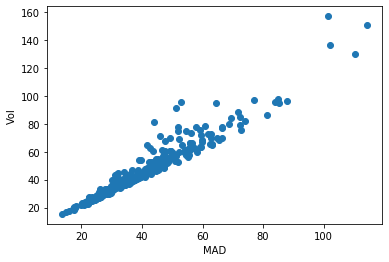

In [76]:
plt.scatter(data['1 Year MAD'],data['1 Year Volatility'])
plt.xlabel('MAD')
plt.ylabel('Vol')